## Import Required Libraries

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualisation lib
import seaborn as sns # data visualisation lib
from sklearn.model_selection import train_test_split # splitting data frame/data set
from sklearn.linear_model import Lasso # importing ML lib
from sklearn.linear_model import Ridge # importing ML lib
from sklearn.metrics import mean_squared_error , r2_score # for accuracy metrics
import joblib # for saving ML model
%matplotlib inline

In [38]:

import io


import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='tjWa-Thqw8P4B0t_-VsoRgeoEOhu3LHnaPgFjmi4BHAJ',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'powerprediction-donotdelete-pr-olesnkntdmdhmv'
object_key = 'Wind_Dataset.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_table(io.BytesIO(body.read()), sep='\t',encoding='utf-16')
data.head(5)


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction in Degree
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


## Loading the DataSet in Python Dataframe using Pandas

# Data Preprocessing and Analysing

## Renaming the Column

In [39]:
data.rename(columns = {'LV ActivePower (kW)':'ActivePower',
                       "Wind Speed (m/s)":"WindSpeed",
                       "Wind Direction in Degree":"WindDirection","Theoretical_Power_Curve (KWh)":"TheoreticalPowerCurve"},
            inplace = True)
data.head(1)

,Date/Time,ActivePower,WindSpeed,TheoreticalPowerCurve,WindDirection
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904


## Handling the null values

In [40]:
data.isnull().sum() # no null values found

Date/Time                0
ActivePower              0
WindSpeed                0
TheoreticalPowerCurve    0
WindDirection            0
dtype: int64

##  to_datetime() method to convert string Date time into Python Date time object

In [41]:
data['Date/Time']=pd.to_datetime(data['Date/Time'])
print(data['Date/Time'].head(5))

0   2018-01-01 00:00:00
1   2018-01-01 00:10:00
2   2018-01-01 00:20:00
3   2018-01-01 00:30:00
4   2018-01-01 00:40:00
Name: Date/Time, dtype: datetime64[ns]


In [42]:
data.describe()

,ActivePower,WindSpeed,TheoreticalPowerCurve,WindDirection
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date/Time              50530 non-null  datetime64[ns]
 1   ActivePower            50530 non-null  float64       
 2   WindSpeed              50530 non-null  float64       
 3   TheoreticalPowerCurve  50530 non-null  float64       
 4   WindDirection          50530 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


##  Creating separate Date, Month, Year, Hour, Minute column

In [44]:
data['year'] = data['Date/Time'].dt.year 
data['month'] = data['Date/Time'].dt.month 
data['day'] = data['Date/Time'].dt.day
data['Hour'] = data['Date/Time'].dt.hour 
data['minute'] = data['Date/Time'].dt.minute 
data.tail(5)

,Date/Time,ActivePower,WindSpeed,TheoreticalPowerCurve,WindDirection,year,month,day,Hour,minute
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23,10
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23,20
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40
50529,2018-12-31 23:50:00,2820.466064,9.979332,2779.184096,82.274620,2018,12,31,23,50


## Understanding the Data Distribution

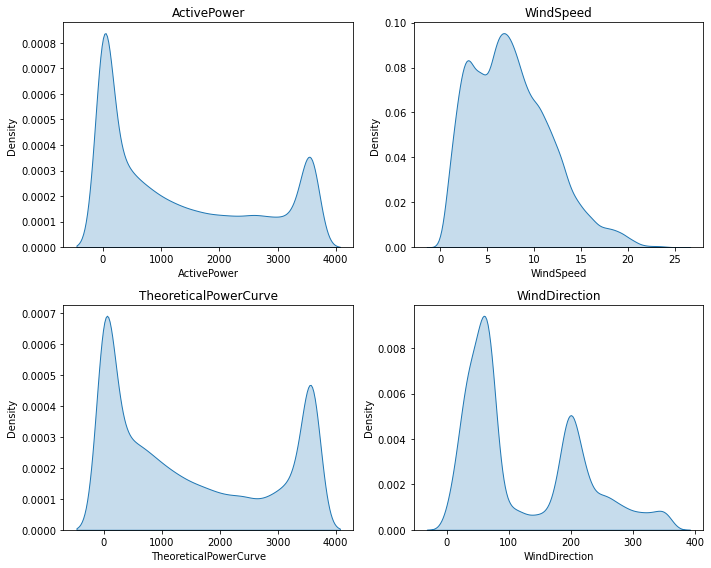

In [45]:
#plotting the data distribution with the help of Matplotlib library
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data.iloc[:,i+1], shade=True)
    plt.title(data.columns[i+1])
plt.tight_layout()
plt.show()

## Round funtion for wind direction

In [46]:
def round_direction(x):
    list=[]
    i=15
    while i<=375:
        list.append(i)
        i+=30
        
    for i in list:
        if x < i:
            x=i-15
            if x==360:
                return 0
            else:
                return x

In [47]:
data["RoundDirection"]=data["WindDirection"].apply(round_direction)
data.head(5)

,Date/Time,ActivePower,WindSpeed,TheoreticalPowerCurve,WindDirection,year,month,day,Hour,minute,RoundDirection
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0,270
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10,270
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20,270
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087,2018,1,1,0,30,270
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40,270


## Assigning the Directions("N","NNE","NEE","E","SEE","SSE","S","SSW","SWW","W","NWW","NNW") with respect to Degrees

In [48]:
direction_dictionary = {0:"N", 30:"NNE", 60:"NEE", 90:"E", 120:"SEE", 150:"SSE", 180:"S", 210:"SSW", 240:"SWW", 270:"W", 300:"NWW", 330:"NNW"}

def direction_of_wind(x):
  for x in direction_dictionary:
    return direction_dictionary[x]

data['WindCDirection'] = data['RoundDirection'].apply(direction_of_wind)
data.tail(3)

,Date/Time,ActivePower,WindSpeed,TheoreticalPowerCurve,WindDirection,year,month,day,Hour,minute,RoundDirection,WindCDirection
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30,90,N
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40,90,N
50529,2018-12-31 23:50:00,2820.466064,9.979332,2779.184096,82.274620,2018,12,31,23,50,90,N


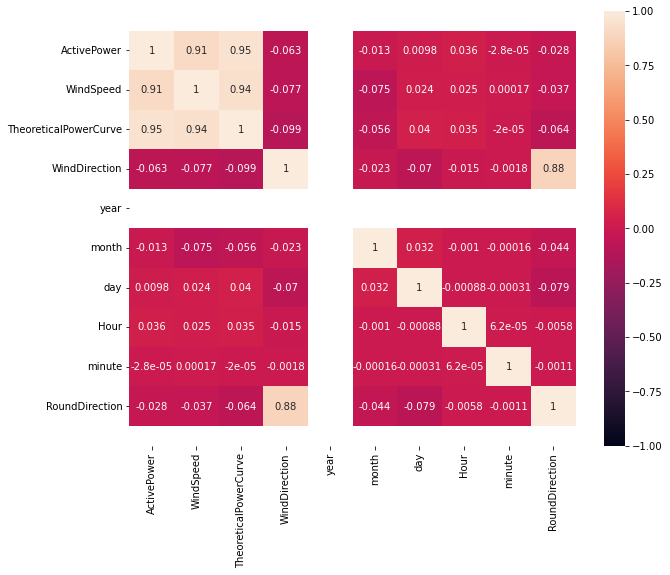

,ActivePower,WindSpeed,TheoreticalPowerCurve,WindDirection,year,month,day,Hour,minute,RoundDirection
ActivePower,1.000000,0.912774,0.949918,-0.062702,NaN,-0.013359,0.009779,0.036355,-0.000028,-0.028036
WindSpeed,0.912774,1.000000,0.944209,-0.077188,NaN,-0.074892,0.023784,0.024754,0.000166,-0.036713
TheoreticalPowerCurve,0.949918,0.944209,1.000000,-0.099076,NaN,-0.055629,0.040273,0.034636,-0.000020,-0.064206
WindDirection,-0.062702,-0.077188,-0.099076,1.000000,NaN,-0.022852,-0.069721,-0.015355,-0.001821,0.880726
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,-0.013359,-0.074892,-0.055629,-0.022852,NaN,1.000000,0.032000,-0.001024,-0.000163,-0.044356
day,0.009779,0.023784,0.040273,-0.069721,NaN,0.032000,1.000000,-0.000883,-0.000310,-0.078696
Hour,0.036355,0.024754,0.034636,-0.015355,NaN,-0.001024,-0.000883,1.000000,0.000062,-0.005810
minute,-0.000028,0.000166,-0.000020,-0.001821,NaN,-0.000163,-0.000310,0.000062,1.000000,-0.001051
RoundDirection,-0.028036,-0.036713,-0.064206,0.880726,NaN,-0.044356,-0.078696,-0.005810,-0.001051,1.000000


In [49]:
correlation = data.corr()
plt.figure(figsize=(10, 8))

ax = sns.heatmap(correlation, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
correlation

## ->WindSpeed, ActivePower, WindDirection are the Highly Correlated Features

## Droping all irrelavent/unwanted features

In [50]:
columns = ['year', 'month', 'day', 'Hour', 'minute','RoundDirection']
data = data.drop(columns, axis=1)

In [51]:
data.head(2)

,Date/Time,ActivePower,WindSpeed,TheoreticalPowerCurve,WindDirection,WindCDirection
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,N
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,N


## Splitting Data into Independent and Dependent Variables 

In [52]:
X=data[['WindSpeed','WindDirection']] #independent features
X.head(3)

,WindSpeed,WindDirection
0,5.311336,259.994904
1,5.672167,268.641113
2,5.216037,272.564789


In [53]:
Y = data['ActivePower'] #dependent features
Y.head(3)

0    380.047791
1    453.769196
2    306.376587
Name: ActivePower, dtype: float64

In [54]:
X.to_csv('Independent_Var.csv')

In [55]:
Y.to_csv('Dependent_Var.csv')

### splitting in train and test data

In [56]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2) #80% training and 20% Testing

## Choose The Appropriate Model

In [57]:
from sklearn.ensemble import RandomForestRegressor # importing the regressor model
Model=RandomForestRegressor(n_estimators=750, max_depth=4, max_leaf_nodes=500, random_state=1)

### fitting the data with the Regressor Model

In [58]:
Model.fit(x_train,y_train) 

RandomForestRegressor(max_depth=4, max_leaf_nodes=500, n_estimators=750,
                      random_state=1)

## Check The Metrics Of The Model

In [59]:
#Predicting for Test Data
Predicted=Model.predict(x_test)
print(Predicted)

[ 159.69193134 1344.48193917 1813.41862227 ...   11.14964803 1813.41862227
  540.28710186]


In [60]:
from sklearn.metrics import mean_absolute_error , r2_score 
#Evaluating the score of our model
print(mean_absolute_error(y_test,Predicted))
print(r2_score(y_test,Predicted))

163.8322133153247
0.9158612410232716


## Save The Model

In [61]:
#Saving the model for future reference
joblib.dump(Model,"power_prediction.sav")

['power_prediction.sav']

In [62]:
!pip install ibm_watson_machine_learning

In [63]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"Ss8jE5G536xMWJlXZo8dVCP8g2qL1DmmMi--dcSgDmR4"
    
}
client = APIClient(wml_credentials)

In [70]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ------  ------------------------
ID                                    NAME    CREATED
3f7b4164-bf09-4db4-ae6d-0d42938669ee  models  2022-11-18T15:12:40.336Z
------------------------------------  ------  ------------------------


In [71]:
space_id = "3f7b4164-bf09-4db4-ae6d-0d42938669ee"

In [72]:
wml_client.set.default_space(space_id)

'SUCCESS'

In [73]:
wml_client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [74]:
MODEL_NAME = 'Predicting the energy output of wind turbine based on weather condition'
DEPLOYMENT_NAME = 'deploy'
POWER_MODEL = Model

In [75]:
software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [76]:
# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [77]:
#Saving the Model
Model_details = wml_client.repository.store_model(
    model=POWER_MODEL, 
    meta_props=model_props, 
    training_data=x_train, 
    training_target=y_train
)

In [78]:
Model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'ActivePower',
  'schemas': {'input': [{'fields': [{'name': 'WindSpeed', 'type': 'float64'},
      {'name': 'WindDirection', 'type': 'float64'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-18T15:14:31.794Z',
  'id': 'b13e4c6b-a300-4cfb-862a-591495e79b1f',
  'modified_at': '2022-11-18T15:14:35.570Z',
  'name': 'Predicting the energy output of wind turbine based on weather condition',
  'owner': 'IBMid-66200434R4',
  'resource_key': '6bb7dc8f-f76d-47f4-8f2f-9f9bf5ff46a5',
  'space_id': '3f7b4164-bf09-4db4-ae6d-0d42938669ee'},
 'system': {'warnings': []}}